# Model_03-SGD-K=3
## Imports

In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

## Load Input Data

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

## Generate the training data
Use band_1 as the first color dimension and band_2 as the second color dimension. I formatted the third color dimension using the average of band_1 and band_2.

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

## Transfer Learning

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.optimizers import SGD
from keras.optimizers import Nadam
from keras.optimizers import Adadelta
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


## Image Transformation
Use the code below to perform the data augmentation.

In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

## Merge two generators

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

## VGG16 Model

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
#     adadelta= Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=adadelta,
#                   metrics=['accuracy'])
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model



## Stratified K-Fold Cross Validation
### K=10

In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=50,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/50
24/24 [==============================] - 17s 703ms/step - loss: 0.8804 - acc: 0.5896 - val_loss: 0.4597 - val_acc: 0.7840
Epoch 2/50
24/24 [==============================] - 12s 506ms/step - loss: 0.4435 - acc: 0.7991 - val_loss: 0.3330 - val_acc: 0.8272
Epoch 3/50
24/24 [==============================] - 12s 502ms/step - loss: 0.3503 - acc: 0.8461 - val_loss: 0.2764 - val_acc: 0.8580
Epoch 4/50
24/24 [==============================] - 12s 485ms/step - loss: 0.3243 - acc: 0.8526 - val_loss: 0.2810 - val_acc: 0.8704
Epoch 5/50
24/24 [==============================] - 12s 507ms/step - loss: 0.3003 - acc: 0.8741 - val_loss: 0.2464 - val_acc: 0.8951
Epoch 6/50
24/24 [==============================] - 12s 487ms/step - loss: 0.2573 - acc: 0.8875 - val_loss: 0.2521 - val_acc: 0.9012
Epoch 7/50
24/24 [==============================] - 12s 489ms/step - loss: 0.2673 - acc: 0.8803 - val_loss: 0.2758 - val_acc: 0.8827
Epoch 8/50
24/24 [=======================

Epoch 25/50
24/24 [==============================] - 12s 494ms/step - loss: 0.1685 - acc: 0.9257 - val_loss: 0.1822 - val_acc: 0.9503
Epoch 26/50
24/24 [==============================] - 12s 495ms/step - loss: 0.1518 - acc: 0.9351 - val_loss: 0.2181 - val_acc: 0.9379
Epoch 27/50
24/24 [==============================] - 12s 496ms/step - loss: 0.1543 - acc: 0.9329 - val_loss: 0.2200 - val_acc: 0.9193
Epoch 28/50
24/24 [==============================] - 12s 494ms/step - loss: 0.1432 - acc: 0.9436 - val_loss: 0.2134 - val_acc: 0.9441
Epoch 29/50
24/24 [==============================] - 12s 496ms/step - loss: 0.1755 - acc: 0.9219 - val_loss: 0.2214 - val_acc: 0.9255
Epoch 30/50
24/24 [==============================] - 12s 495ms/step - loss: 0.1487 - acc: 0.9397 - val_loss: 0.2297 - val_acc: 0.9379
Train loss: 0.137933181347
Train accuracy: 0.948717948718
Test loss: 0.167097230415
Test accuracy: 0.95652173913

===================FOLD= 2
Epoch 1/50
24/24 [==============================] - 13s

24/24 [==============================] - 12s 515ms/step - loss: 0.2276 - acc: 0.9108 - val_loss: 0.2831 - val_acc: 0.8875
Epoch 9/50
24/24 [==============================] - 12s 496ms/step - loss: 0.2227 - acc: 0.9054 - val_loss: 0.3015 - val_acc: 0.8812
Epoch 10/50
24/24 [==============================] - 12s 515ms/step - loss: 0.2025 - acc: 0.9194 - val_loss: 0.2693 - val_acc: 0.8750
Epoch 11/50
24/24 [==============================] - 12s 495ms/step - loss: 0.2113 - acc: 0.9081 - val_loss: 0.2969 - val_acc: 0.8875
Epoch 12/50
24/24 [==============================] - 12s 495ms/step - loss: 0.1980 - acc: 0.9160 - val_loss: 0.3512 - val_acc: 0.8562
Epoch 13/50
24/24 [==============================] - 12s 495ms/step - loss: 0.2062 - acc: 0.9134 - val_loss: 0.2810 - val_acc: 0.8938
Epoch 14/50
24/24 [==============================] - 12s 496ms/step - loss: 0.1899 - acc: 0.9241 - val_loss: 0.2735 - val_acc: 0.9000
Epoch 15/50
24/24 [==============================] - 12s 514ms/step - loss:

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_SGD_10folds.csv', index=False)

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


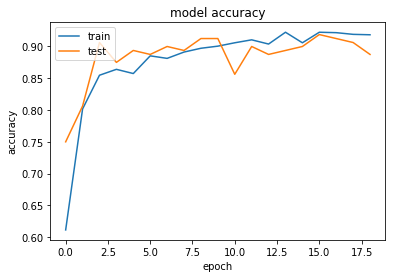

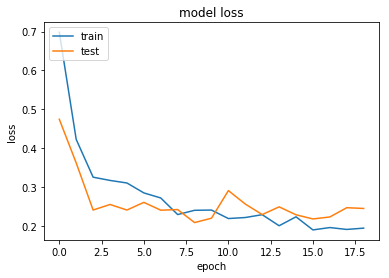

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

## Prediction Result
### Compare actual and predicted values with some validation set images

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
X_holdout2.shape

(160, 75, 75, 3)

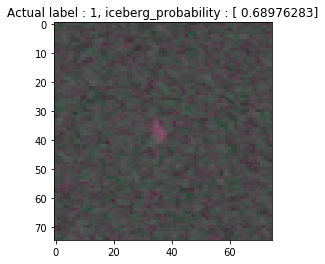

In [18]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

In [17]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

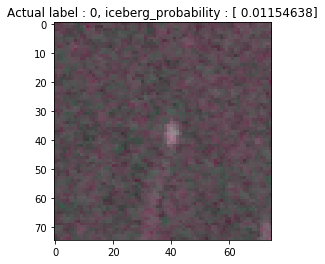

In [19]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

In [20]:
pred_valid.shape

(160, 1)

In [21]:
Y_holdout.shape

(160,)

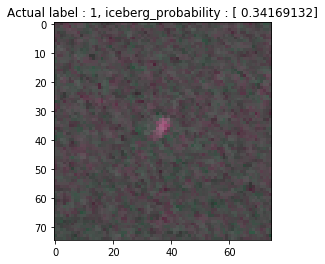

In [22]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

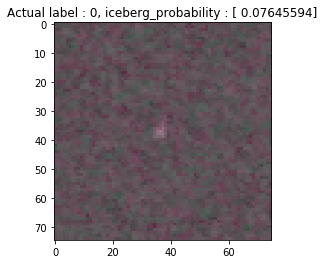

In [23]:
plt.imshow(X_holdout2[159], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[1602])+ ","+" iceberg_probability : "+str(pred_valid[159])
plt.title(tl)

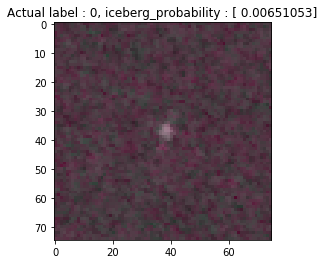

In [24]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)